In [1]:
@everywhere push!(LOAD_PATH,"./");
using fdfd, PyPlot

# Radiating dipole example
This demonstrates a simple dipole radiating in free space. Although there is an assign_epsr!() call here, it sets $\epsilon_r = 1$ and therefore has no effect.

# Solver:   PARDISO failed, falling back to lufact()

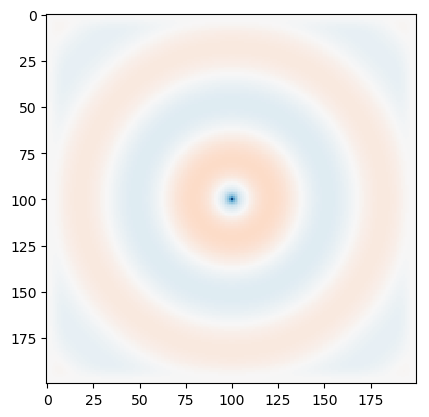

In [2]:
omega = 2*pi*200e12
N = (200,200);
Npml = (15,15)
xrange = (-2.5e-6,2.5e-6);
yrange = (-2.5e-6,2.5e-6);
geom = Geometry2D(N, Npml, xrange, yrange);

region_func(x,y) = -0.25e-6<=x<=0.25e-6 && -0.1e-6<=y<=0.1e-6;
setϵᵣ!(geom, region_func, 1);
setpointJ!(geom, (0, 0));

(Ez, Hx, Hy) = solve_driven_TM(geom, omega);
imshow(real.(Ez), cmap="RdBu", vmin=-maximum(abs.(Ez)),vmax=maximum(abs.(Ez)));
show();

# Photonic waveguide transition
This demonstrates an indirect photonic mode transition in a waveguide. The even mode is launched from the left and is converted to the odd mode as it propagates.

# Solver: Setup
# Solver: Number of sidebands: 1
# Solver: Number of frequency components: 3
# Solver: Number of unknowns: 3.60E+05
# Solver: Assembly
# Solver:   Calculating system matrix
# Solver:   using frequency-by-frequency PML
# Solver:   Calculating coupling matrix
# Solver:   Calculating total matrix
# Solver: Solving
# Solver:   PARDISO failed, falling back to lufact()


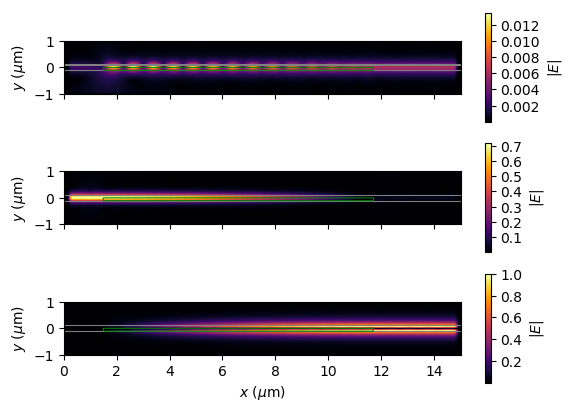

# Solver: Extracting results


In [3]:
omega0 = 2*pi*1.939e14;
Omega = 4.541e14;

Nsb = 1;
N = (600,200);
Npml = (15,10)
xrange = (0.0,15e-6);
yrange = (-1e-6,1e-6);
a = 0.2202e-6;
q = 2.9263e6;
Δϵ = 1;

geom = Geometry2D(N, Npml, xrange, yrange);
mod = Modulator(geom, Omega, Nsb);

region_wg(x,y) = -a/2<=y<=a/2;
region_modulation(x,y) = 1.5e-6<=x<=11.7e-6 && -a/2<=y<=0;
modulation_function(x,y) = Δϵ*exp.(1im*q*x);

setϵᵣ!(mod.geom, region_wg, 12.25);
setΔϵᵣ!(mod, region_modulation, modulation_function);
setmodeJ!(mod.geom, "TM", omega0, omega0/c₀*3.5, [1e-6,0], "x", 61);

(Ez, Hx, Hy, omega) = solve_modulation_TM(mod, omega0, verbose=false, sharedpml=false);
plot_fields_abs(mod, Ez, cbar=true);